In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import binary_crossentropy

import sys
sys.path.append('../')
from supervised import LogisticRegression
from unsupervised.clustering import KMeans

## Goals of this notebook

For this notebook, I hope to compare my own implementation of Logistic Regression with one implemented by scikit-learn. Although, before I do this I need some data to work with. I will start with a simple linearly separable example, then will move to a more complex example.

### Creating our dataset

I am not really sure the optimal approach to generating a dataset for classification. So, why not try a super naive yet simple approach.

__IMPLEMENTATION 1:__
Randomly init n centroids and generate points around each centroid using a normal distribution. Then, assign each point a label based on the centroid it is closest to (Use KMeans here). This last point is to remove overlap of data which will help for separability later.


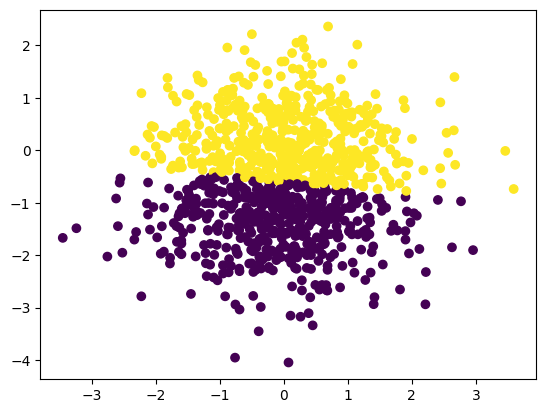

In [4]:
def generate_dataset_for_classification(n_samples, n_features, n_classes, center_box: tuple = (-10.0, 10.0), random_state: int = 42):
    np.random.seed(random_state)
    centers = np.random.uniform(low=center_box[0], high=center_box[1], size=(n_classes, n_features))
    X = np.zeros((n_samples, n_features))
    y = np.zeros((n_samples, 1))
    for i in range(n_samples):
        center = np.random.choice(n_classes)
        sample = np.random.normal(loc=centers[center], scale=1.0)
        X[i, :] = sample
    
    # TODO implement own version of Kmeans
    kmeans = KMeans(n_clusters=n_classes)
    kmeans.fit(X)
    y = kmeans._labels
    return X, y
    

X, y = generate_dataset_for_classification(1000, 2, 2, center_box=(-1,1), random_state=2)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()